# MNIST Dataset with CNN

In this notebook, we will demonstrate how to use the JLNN to build a simple Convolutional Nerual Network to classify the MNIST dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
include("../src/NN.jl")
using NN
using PyPlot

# Data Preparation

In this section, we will prepare the MNIST dataset to train the classifier. MNIST dataset contains 60000 grey-scale images, each of which has dimensions 28x28. We will flatten these data so that each image will become a vector of 784 dimensions, and the label will be between 0 and 9.

We also split the data into training, validation and testing sets. The corresponding ratio of those data sets are 80%, 10% and 10%.

In [7]:
include("../util/datasets.jl")
X, Y = mnistData(ttl=50000)
println("Raw Datset Sizes: $(size(X)), $(size(Y))")

train_set, test_set, validation_set = datasplit(X, Y)
trX, trY   = train_set
valX, valY = validation_set
teX, teY   = test_set

# the reshape the images into something Convolution layer could parse
trX  = permutedims(reshape(trX,  (size(trX,1),  1, 28, 28)), [3,4,2,1])
valX = permutedims(reshape(valX, (size(valX,1), 1, 28, 28)), [3,4,2,1])
teX  = permutedims(reshape(teX,  (size(teX,1),  1, 28, 28)), [3,4,2,1])

size(trX),size(trY),size(valX),size(valY),size(teX),size(teY)

Raw Datset Sizes: (50000,784), (50000,1)


((28,28,1,40000),(40000,1),(28,28,1,5000),(5000,1),(28,28,1,5000),(5000,1))

# Network Structure

In this task, we will use a really simple CNN. There are two convolution layers, each with filter of size (5,5). The first convolution layer contains 32 filter, and the second one doubles this number. Each convolution layer is followed by a maxpolling that down sample the image by a 2x2 pool. After the convolution layers, we will add a perceptron with one single hidden layer with 512 units. FOr the loss function, we will use softmax cross entropy.

The way to defined such classifier in JLNN is really simple:

In [14]:
function simple_cnn(;batch_size = 100)
    layers = Layer[
        InputLayer((28,28,1,batch_size)),
        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        CaffeConvLayer(32,(5,5)),
        ReLu(),
        MaxPoolingLayer((2,2)),

        FlattenLayer(),

        DropoutLayer(0.5),
        DenseLayer(256),
        ReLu(),

        DropoutLayer(0.5),
        DenseLayer(10)
    ]

    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = simple_cnn();

Kernel Statistics[0.45883146774112354]: 0.23606078816936904 0.458183910900486 -0.45805242188654555


Kernel Statistics[0.12009611535381536]: 0.06009273463748168 0.12008572470882296 -0.12008656169697221


# Training and Optimizations

In this section, we train our network to learn the MNIST dataset. The network is consist of one FC layer, one cross-Entropy with soft max layer, and one sequential net. The training function we choose is the simple stochastic gradient descent.

In [19]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end
function train(net::SequentialNet, train_set, validation_set;
    batch_size::Int64 = 100, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), alpha::Float64 = 0.9, verbose=0)
    X, Y = train_set
    valX, valY = validation_set
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []

    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            time_used = @elapsed begin
                batch += 1
                local sidx::Int = convert(Int64, bid*batch_size+1)
                local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
                local batch_X = X[:,:,:,sidx:eidx]
                local batch_Y = Y[sidx:eidx,:]
                loss, pred = forward(net, batch_X, batch_Y)
                backward(net, batch_Y)
                for i = 1:length(net.layers)
                    layer = net.layers[i]
                    gradi = getGradient(layer)
                    for j = 1:length(gradi)
                        gradi[j] = lrSchedule(epo) * gradi[j] / batch_size
                    end

                    veloc = getVelocity(layer)
                    for j = 1:length(veloc)
                        veloc[j] = veloc[j] * alpha - gradi[j]
                    end

                    param = getParam(layer)
                    for j = 1:length(param)
                        param[j] = param[j] + alpha * veloc[j] - gradi[j]
                    end
                    setParam!(layer, param)
                end
                
                append!(all_losses, mean(loss))
                epo_cor  += get_corr(pred, batch_Y)
                local acc = get_corr(pred, batch_Y) / batch_size
            end
            if bid % 20 == 0
                println("[$(bid)/$(num_batch)]($(time_used)s) Loss is: $(mean(loss))\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)

        # Run validation set
        v_ls, v_pd = forward(net, valX, valY)
        local v_loss = mean(v_ls)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pd, valY) / v_size
        append!(val_losses, v_loss)
        append!(val_accu,   v_accu)

        println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
    end
    return epo_losses,epo_accus, val_losses, val_accu
end

train (generic function with 1 method)

In [ ]:
batch_size = 500
net = simple_cnn(batch_size=batch_size)
epo_losses, epo_accu, val_losses, val_accu = train(net, (trX, trY), (valX, valY);
                ttl_epo = 100, batch_size = batch_size, lrSchedule = x -> 0.01, verbose=1, alpha=0.9)

figure(figsize=(12,6))
subplot(221)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(222)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()

subplot(223)
plot(1: length(val_losses), val_losses)
title("Validation Losses")
show()

subplot(224)
plot(1: length(val_accus), val_accus)
title("Validation Accuracy")
show()


Kernel Statistics[0.45883146774112354]: 0.23466659797189146 0.45802929198856507 -0.4571390727161363
Kernel Statistics[0.12009611535381536]: 0.05961683930230712 0.12009196425544812 -0.1200922926233572
[0.0/80.0](2.095250841s) Loss is: 9.46419916564052	Accuracy:0.106
[20.0/80.0](1.780528299s) Loss is: 2.2101947901355827	Accuracy:0.2
[40.0/80.0](1.824642894s) Loss is: 1.7822489314993466	Accuracy:0.368
[60.0/80.0](1.808904511s) Loss is: 1.574928526520182	Accuracy:0.454
Input layer shape update:(28,28,1,5000)
ConvLayer update shape:
	Input:(28,28,1,5000)
	Output:(24,24,32,5000)
(28,28,1,5000)	(24,24,32,5000)	(28,28,1,5000)	(24,24,32,5000)
MaxPooling Layer update shape:
	Input:(24,24,32,5000)
	Output:(12,12,32,5000)
ConvLayer update shape:
	Input:(12,12,32,5000)
	Output:(8,8,32,5000)
(12,12,32,5000)	(8,8,32,5000)	(12,12,32,5000)	(8,8,32,5000)
MaxPooling Layer update shape:
	Input:(8,8,32,5000)
	Output:(4,4,32,5000)
FlattenLayer update:
	Input:(4,4,32,5000)
	Output:(5000,512)
DropoutLayer upd

In [11]:
function test(teX, teY; batch_size = 100)
    ttl_corr, ttl = 0, 0
    right_idx = []
    wrong_idx = []
    ttl_pred = []
    N = size(teX)[1]
    for i = 1:batch_size:N
        x, y = teX[i:i+batch_size-1,:], teY[i:i+batch_size-1,:]
        _, pred = forward(net, x, y; deterministics =  true)
        for j = 1:batch_size
            ttl_corr += length(filter(i-> abs(pred[i] - y[i]) <  1e-5, 1:batch_size))
            if abs(pred[j] - y[j]) < 1e-5 # correct 
                ttl_corr += 1
                append!(right_idx, j)
            else # incorrect
                append!(wrong_idx, j)
            end
            ttl+=1
            append!(ttl_pred, pred[j])
        end
    end
    return ttl_pred, right_idx, wrong_idx, ttl_corr, N
end
pred, right_idx, wrong_idx, corr, N = test(teX, teY; batch_size = 100)
println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()

LoadError: BoundsError: attempt to access 28×28×1×5000 Array{Float64,4} at index [1:100,Colon()]

# Use Gradient Descend to Generate Aversarial Images

In this section below, we will introduce how to use gradient descend on the input images to generate an adversarial training example that will differ from the original image by a really small difference.

The idea will be pretty simple: we will pick an image with that's originally classified to certain label, then we will propogate this image through the network compute the gradient of this image. Formally, suppose the image is $x$ and the network has output $f(x)$ with loss function $\mathcal{L}$, then we could use the simple backward pass to calculate $\frac{\partial \mathcal{L}}{\partial x}$. This value tells us the direction where we could move our images to increase the loss. Instead of updating the parameter of the layers, we will update the image to lower the loss:
$$x = x - \alpha \frac{\partial \mathcal{L}}{\partial x}$$

The surprising fact is that although the generated images almost remain the same, but the network will classify it incorrectly in to a different label.

Original Label:[6.0]	Target label:[9.0]


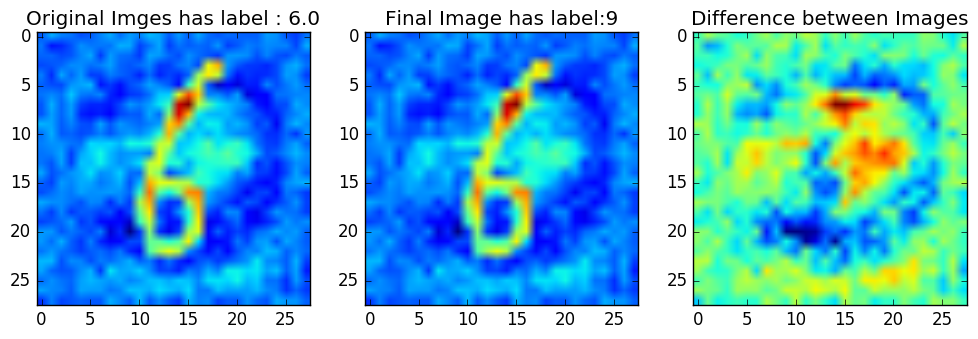

Average magtitude of the permutation:0.10996705044591108


In [12]:
idx   = convert(Int, ceil(rand() * size(trX)[1]))
alpha = 0.1
inpx  = trX[idx:idx,:]
t     = trY[idx:idx,:]

target = (t[1,:] + 3) % 10
println("Original Label:$(t[1,:])\tTarget label:$(target)")
t[1,:] = target
verbose = false
for i = 1:10000
    loss, _ = forward(net, inpx, t)
    dldx = backward(net, t)
    inpx -= alpha * dldx
    if i % 2000 == 1 && verbose
        println("Iteration $(i), loss:$(mean(loss)), dldx:$(sum(abs(dldx)))")
        figure(figsize=(2,2))
        imshow(reshape(inpx[1,:], 28,28))
        show()
    end
end

figure(figsize=(12,4))
subplot(131)
imshow(reshape(inpx, 28,28))
title("Original Imges has label : $(trY[idx])")

_, pred = forward(net, inpx, t)
subplot(132)
imshow(reshape(inpx[1,:], 28,28))
title("Final Image has label:$(pred[1])")

subplot(133)
imshow(reshape(inpx - trX[idx:idx,:], 28,28))
title("Difference between Images")
show()

println("Average magtitude of the permutation:$(mean(abs(inpx -trX[idx:idx,:])))")